In [121]:
from importlib import reload # useful during development to reload packages

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
import lightkurve_ext_tls as lke_tls

from astropy import units as u
from astropy.time import Time

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as matplotlib

from IPython.display import display, HTML, Audio
display(HTML("<style>.container { width:99% !important; }</style>"))

%matplotlib inline

display(HTML("""<style id="hide-beep-css" type="text/css">
  #beep { /* hide the audio control for the beep, generated from tplt.beep() */
    width: 1px;
    height: 1px;
  }
</style>"""));
        
def beep():
    beep_url = "https://upload.wikimedia.org/wikipedia/commons/f/fb/NEC_PC-9801VX_ITF_beep_sound.ogg"    
    display(Audio(url=beep_url, autoplay=True, embed=True, element_id="beep"))

In [109]:
tic, sector, to_detrend = 159951311, 3, False  # WASP-139, very easy
# tic, sector, to_detrend = 270472265, 37, False  # TOI, easy
# tic, sector, to_detrend = 165827520, 37, False  # TOI 3494.01, less obvious (shallower dips but can still be spotted visually)
# tic, sector, to_detrend = 272167060, 37, True   # TOI 3495.01, the shallowest, plus additional long-term variation

max_num_sectors_to_download = 3

# max_num_sectors_to_download = None  # download all sectors, set it to a number to cap it, with the supplied sector as the centor of the slice to donwload

# one-time config for query cache
lk.search.sr_cache.cache_dir = 'data'

def limit_sr_to_download(sr):
    if max_num_sectors_to_download is None:
            return sr
    return lke.of_sector_n_around(sr, sector, num_additions=max_num_sectors_to_download-1)

try:    
    lcf_coll, sr, sr_unfiltered = lke.download_lightcurves_of_tic_with_priority(tic, download_filter_func=limit_sr_to_download, download_dir="./data")
finally:
    beep()  # a beep to remind the users that the data has been downloaded

lcf_coll

Note: there are products not supported by Lightkurve, which are excluded from download.
9 rows filtered ; 2 fast (20secs) products.


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 03,2018,SPOC,120,159951311,0.0
1,TESS Sector 04,2018,SPOC,120,159951311,0.0
2,TESS Sector 30,2020,SPOC,120,159951311,0.0
3,TESS Sector 31,2020,SPOC,120,159951311,0.0


2% (272/15973) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
INFO:lightkurve.utils:2% (272/15973) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
2% (354/18921) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
INFO:lightkurve.utils:2% (354/18921) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 159951311 	#sectors: 3 ; 3 - 30
   sector 30: 	camera = 3 ; ccd = 1


LightCurveCollection of 3 objects:
    0: <TessLightCurve LABEL="TIC 159951311" SECTOR=3 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 159951311" SECTOR=4 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 159951311" SECTOR=30 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

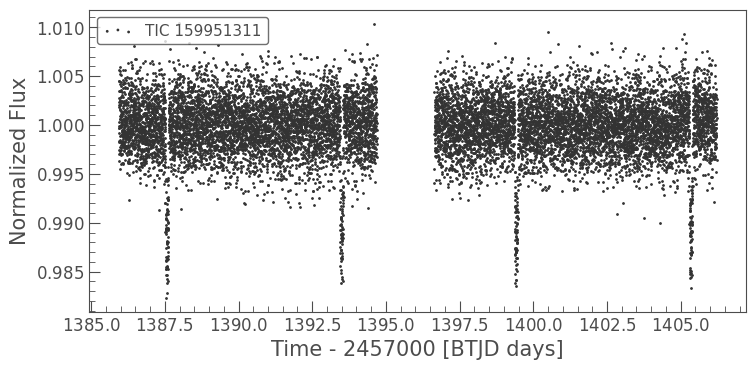

In [110]:
lc_stitched = (
    of_sectors(lcf_coll, sector)
#     of_sectors(lcf_coll, 37, 38)
    .stitch()  # stitch also normalize the flux, needed for TLS
    .remove_outliers(sigma=7)
    .remove_nans()
)

lc = lc_stitched   # .truncate(2308.5, None)
lc.scatter()

In [70]:
window_length = 24 / 24

if to_detrend:
  lc_flattend = lc_stitched.flatten(window_length=lke.to_window_length_for_2min_cadence(window_length))
  with plt.style.context(lk.MPLSTYLE):
        ax = plt.figure(figsize=(30, 6)).gca()
  ax = lc_flattend.scatter(ax=ax)
  lc = lc_flattend

In [111]:
def plot_pg_n_mark_max(pg, ax=None):
    ax = pg.plot(ax=ax, view="period")
    ax.axvline(pg.period_at_max_power.value, c="blue", alpha=0.4)
    max_text = f"Power: {pg.max_power:.2f}, Period: {pg.period_at_max_power:.2f}, Depth: {pg.depth_at_max_power:.3f}"
    x, y = pg.period_at_max_power.value, pg.max_power * 0.9
    x_mid = ((pg.period.max() - pg.period.min()) / 2 + pg.period.min()).value
    horizontalalignment = "left" if x < x_mid else "right"
    ax.text(x, y, " " + max_text + " ", c="blue", horizontalalignment=horizontalalignment)
    return ax

DEBUG:lightkurve_ext_tls:TLS.from_lightcurve() args: {'derive_stellar_priors': True, 'use_threads': 6, 'show_progress_bar': True, 'n_transits_min': 1}
DEBUG:lightkurve_ext_tls:catalog_info() elapsed time: 244.697509765625ms
DEBUG:lightkurve_ext_tls:TLS.from_lightcurve() - tls.power() args: {'use_threads': 6, 'show_progress_bar': True, 'n_transits_min': 1, 'u': (0.4136, 0.1999), 'R_star': 0.846671, 'R_star_min': 0.7917137, 'R_star_max': 0.9016282999999999, 'M_star': 0.87, 'M_star_min': 0.763788, 'M_star_max': 0.976212}
  0%|                                                                    | 0/2427 periods | 00:00<?

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 41 durations
Searching 13032 data points, 2427 periods from 0.502 to 20.278 days
Using 6 of 12 CPU threads


100%|█████████████████████████████████████████████████████████████| 2427/2427 periods | 00:08<00:00


lightkurve.Periodogram properties:
        Attribute                   Description            Units
------------------------- -------------------------------- -----
                 targetid                        159951311      
             default_view                           period      
                    label                    TIC 159951311      
                time_unit                              day      
       depth_at_max_power                           0.0114      
    duration_at_max_power                           0.1154     d
  false_alarm_probability                           0.0001      
   frequency_at_max_power                           0.1688 1 / d
                max_power                           17.446      
      period_at_max_power                           5.9245     d
  period_at_max_power_err                           0.0355     d
         snr_at_max_power                          64.1972      
                     chi2                    array (242

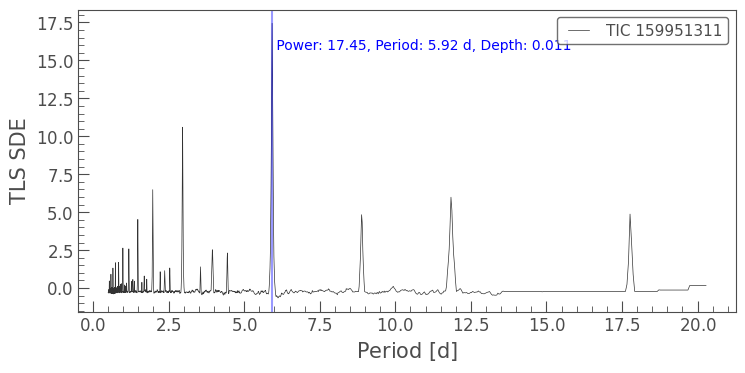

In [112]:
# reload(lke_tls)

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('lightkurve_ext_tls')
logger.setLevel(logging.DEBUG)

pg = lke_tls.TransitLeastSquaresPeriodogram.from_lightcurve(lc, 
                                                            derive_stellar_priors=True, 
                                                            use_threads=6,
                                                            show_progress_bar=True,
#                                                             minimum_period=10 * u.day,
#                                                             maximum_period=26 * u.day,
                                                            # for typical TESS 1-sector data, TLS's default will prevent users from finding 2 transits within 1 sector, overriding it
                                                            n_transits_min=1 # override the default 2, which could override maximum_period if lc's duration / 2 < maximum_period given
                                                           )
pg.show_properties();
print("transit_time_at_max_power ", pg.transit_time_at_max_power)
plot_pg_n_mark_max(pg);

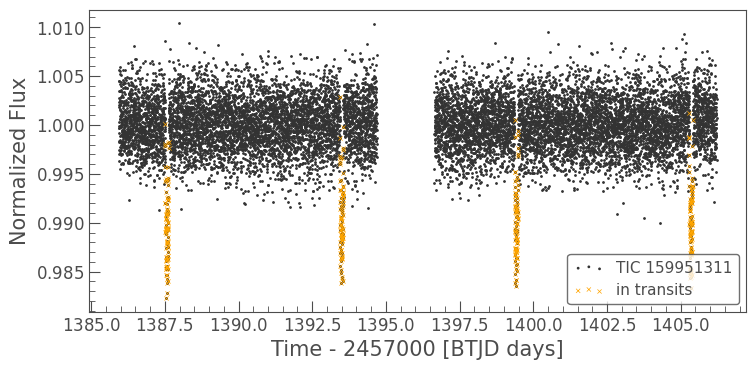

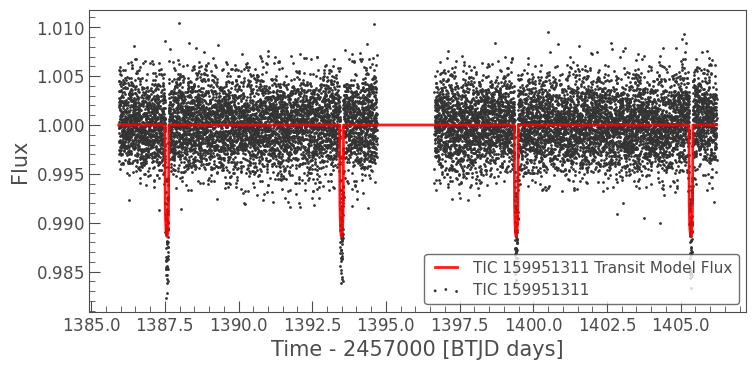

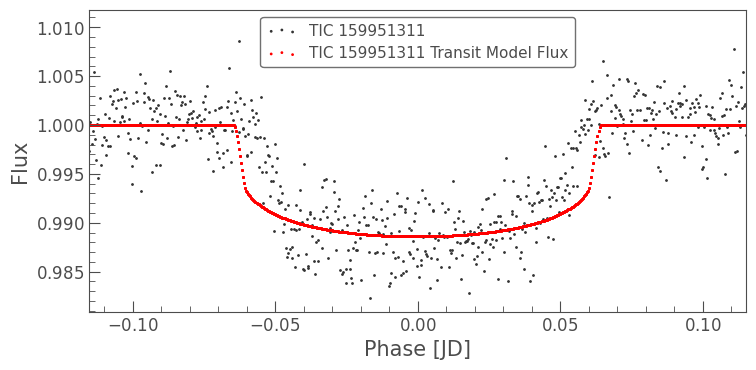

In [113]:
# with plt.style.context(lk.MPLSTYLE):
#     ax = plt.figure(figsize=(15, 6)).gca()
ax = lc.scatter();
lc[pg.get_transit_mask()].scatter(ax=ax, c="orange", marker="x", s=9, label="in transits");

ax = lc.scatter();
pg.get_transit_model().plot(ax=ax, c="red", alpha=0.9, linewidth=2);

# folded, zoom -in
lc_f, lc_model_f = pg.fold(lc)
ax = lc_f.scatter()
lc_model_f.scatter(ax=ax, c="red");
ax.set_xlim(-pg.duration_at_max_power.value, pg.duration_at_max_power.value);

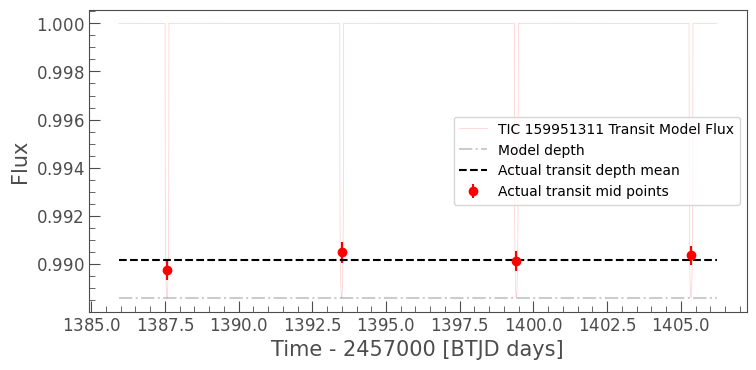

In [116]:
# Check if the transit depths are consistent
def errorbar_transit_depth(pg):
    lc_model = pg.get_transit_model()
    ax = lc_model.plot(c="red", alpha=0.2)
    
    time = [lc_model.time.min().value, lc_model.time.max().value]    
    ax.plot(time, [1 - pg.depth_at_max_power, 1 - pg.depth_at_max_power], linestyle="-.", c="black", alpha=0.2, label="Model depth")

    transit_depth_mean = np.mean(pg.transit_depth)
    ax.plot(time, [1 - transit_depth_mean , 1 - transit_depth_mean ], linestyle="--", c="black", label="Actual transit depth mean")
    
    ax.errorbar(pg.transit_time.value, 1 - pg.transit_depth, pg.transit_depth_err, fmt='o', color='red', label="Actual transit mid points")
    ax.legend()
    return ax

errorbar_transit_depth(pg);

In [199]:
from transitleastsquares import catalog_info

ab, mass, mass_min, mass_max, radius, radius_min, radius_max = catalog_info(TIC_ID=lc.targetid)
ab, mass, mass_min, mass_max, radius, radius_min, radius_max

((0.3454, 0.2253),
 array(1.07),
 array(nan),
 array(nan),
 array(1.13756),
 array(nan),
 array(nan))

In [117]:
pg._TLS_result

{'SDE': 18.636211231302838,
 'SDE_raw': 17.79355339961697,
 'chi2_min': 562.5031104756602,
 'chi2red_min': 0.5569337727481783,
 'period': 2.750437978957704,
 'period_uncertainty': 0.01119225216105968,
 'T0': 2310.3722218435714,
 'duration': 0.08459352011224947,
 'depth': 0.9908664436470078,
 'depth_mean': (0.9920493522111107, 0.0005563816648482153),
 'depth_mean_even': (0.9917795938604018, 0.000801436074378527),
 'depth_mean_odd': (0.9923191105618197, 0.000766408064271885),
 'transit_depths': array([0.99123509, 0.99107753, 0.9914417 , 0.99300905,        nan,
        0.9911214 , 0.99056575, 0.9937186 , 0.99345659]),
 'transit_depths_uncertainties': array([0.00155261, 0.00083262, 0.00180983, 0.0011195 ,        nan,
        0.00140008, 0.00088529, 0.00182914, 0.00155576]),
 'rp_rs': 0.08594628380844878,
 'snr': 26.70338847220772,
 'snr_per_transit': array([10.09721826, 10.2787338 ,  9.85920871,  8.05361488,  0.        ,
        10.22819647, 10.8683074 ,  8.0903225 ,  8.42778648]),
 'snr_p

lightkurve.Periodogram properties:
        Attribute                   Description            Units
------------------------- -------------------------------- -----
                 targetid                        159951311      
             default_view                           period      
                    label                    TIC 159951311      
                time_unit                              day      
       depth_at_max_power                           0.0106      
    duration_at_max_power                              0.1     d
   frequency_at_max_power                           0.1686 1 / d
                max_power                        2225.6762      
      period_at_max_power                           5.9303     d
                    depth                    array (2361,)      
                 duration                    array (2361,)     d
                     flux                   array (13032,)      
                frequency                    array (236

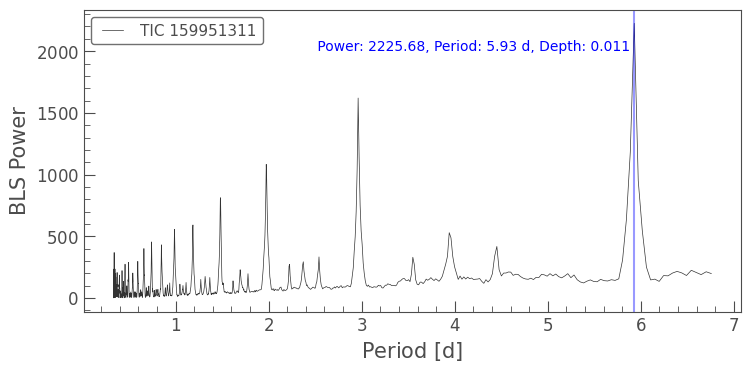

In [117]:
pg_bls = lc.to_periodogram(method="bls"
#                            , minimum_period=10, maximum_period=30
                          )
pg_bls.show_properties()
plot_pg_n_mark_max(pg_bls);